In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from datetime import date
import matplotlib.pyplot as plt
from prophet import Prophet
from trading_strategy.utils.price_transforms import (rsi, adx, plus_di, minus_di, macd, momentum, cci, cmo, trix, 
    ultosc, obv, ad_line, adosc, atr, natr, avgprice, medprice, typprice, wclprice, cdl_doji, cdl_engulfing, cdl_hammer,
    cdl_shootingstar, roc, rocp, rocr, rocr100, williams_r, adxr, apo, ppo, stoch, stochf, stochrsi)
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
START_DATE = "2010-01-01"
END_DATE = "2025-07-01"
RISK_FREE_RATE = 0.045

Choose stable tickers + newest tickers on market from S&P 500

In [4]:
# get list of tickers for s&p 500
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# tickers = list(df['Symbol'].unique())

In [5]:
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
# S&P 500 stocks have been in the index for more than 20 years
df['year'] = pd.to_datetime(df['Date added']).dt.year
len(df[(date.today().year - df['year']) > 20]['Symbol'].unique())

218

In [7]:
tickers = set(df[(date.today().year - df['year']) > 20]['Symbol'])
tickers.update(set(df[df['year'] >= 2020]['Symbol']))

In [8]:
len(tickers)

300

### Collect data

In [9]:
# Download historical closing price data
data = yf.download(tickers, start=START_DATE, end=END_DATE, auto_adjust=True)

[*********************100%***********************]  300 of 300 completed

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2025-07-01)')


In [10]:
data.shape

(3896, 1501)

### Add base features

In [11]:
data.head()

Price      Adj Close      Close                                      \
Ticker          BF.B          A      AAPL ABNB        ABT      ACGL   
Date                                                                  
2010-01-04       NaN  19.931618  6.424605  NaN  18.496666  7.601905   
2010-01-05       NaN  19.715113  6.435713  NaN  18.347233  7.576549   
2010-01-06       NaN  19.645056  6.333344  NaN  18.449121  7.543795   
2010-01-07       NaN  19.619596  6.321635  NaN  18.601959  7.499420   
2010-01-08       NaN  19.613224  6.363664  NaN  18.697060  7.484628   

Price                                                   ...    Volume  \
Ticker           ADBE        ADI        ADM        ADP  ...       WMB   
Date                                                    ...             
2010-01-04  37.090000  22.062075  20.791332  26.033319  ...   7020240   
2010-01-05  37.700001  22.027246  20.903646  25.893515  ...   7415481   
2010-01-06  37.619999  21.985441  20.850800  25.832729  ...  12157139   
2010-01-07  36.889999  21.811291  20.632776  25.820576  ...   6181305   
2010-01-08  36.689999  21.936680  20.375113  25.784109  ...   4703754   

Price                                                                  \
Ticker           WMT      WSM     WST       WY      XEL       XOM XYZ   
Date                                                                    
2010-01-04  62259300  3979400  232800  1832400  2670400  27809100 NaN   
2010-01-05  46945200  4343200  245800  1724500  4321400  30174700 NaN   
2010-01-06  37551600  7698400  272800  2254400  2164500  35044700 NaN   
2010-01-07  31988100  9442600  130600  1420700  3041700  27192100 NaN   
2010-01-08  34089600  5634200  146200  1310000  1599100  24891800 NaN   

Price                         
Ticker          YUM      ZBH  
Date                          
2010-01-04  2962274   805872  
2010-01-05  3298757  1769643  
2010-01-06  4178981  1315619  
2010-01-07  2452472  1734005  
2010-01-08  3772392  2213985  

[5 rows x 1501 columns]

In [12]:
df = pd.DataFrame()
for idx_ticker, ticker in enumerate(tqdm(tickers, desc="Processing tickers", unit="ticker")):
    idx = pd.IndexSlice
    tmp = data.loc[:, idx[:, ticker]]
    tmp.columns = [i[0] for i in tmp.columns]
    tmp.reset_index(inplace=True)
    tmp['Date'] = pd.to_datetime(tmp['Date'])
    tmp.loc[:,'prev_close_price'] = tmp['Close'].shift(1)
    tmp['ticker'] = ticker
    # historical growth
    for days in [1,3,7,30,90,252,365]:
        tmp.loc[:, f'growth_{days}d'] = tmp['Close'] / tmp['Close'].shift(days)
    tmp['roll_mean_10d']= tmp['Close'].rolling(10).mean().reset_index()['Close']
    tmp['roll_mean_20d']= tmp['Close'].rolling(20).mean().reset_index()['Close']
    tmp['growing_moving_average'] = np.where(tmp['roll_mean_10d'] > tmp['roll_mean_20d'], 1, 0)
    tmp['high_minus_low_relative'] = (tmp.High - tmp.Low) / tmp['Close']
    # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
    # 252 triding days in a year
    tmp['volatility'] = tmp['growth_1d'].rolling(30).std().reset_index()['growth_1d'] * np.sqrt(252)
    tmp['sharpe'] = (tmp['growth_252d'] - RISK_FREE_RATE) / tmp['volatility']
    
    # ---- Indicators ----
    tmp["RSI"] = rsi(tmp["Close"], period=14)
    tmp["ADX"] = adx(tmp["High"], tmp["Low"], tmp["Close"], period=14)
    tmp["+DI"] = plus_di(tmp["High"], tmp["Low"], tmp["Close"], period=14)
    tmp["-DI"] = minus_di(tmp["High"], tmp["Low"], tmp["Close"], period=14)
    
    macd_line, signal_line, hist = macd(tmp["Close"])
    tmp["MACD"] = macd_line
    tmp["MACD_signal"] = signal_line
    tmp["MACD_hist"] = hist
    
    tmp["CCI"] = cci(tmp["High"], tmp["Low"], tmp["Close"])
    tmp["CMO"] = cmo(tmp["Close"])
    tmp["TRIX"] = trix(tmp["Close"])
    tmp["ULTOSC"] = ultosc(tmp["High"], tmp["Low"], tmp["Close"])
    
    tmp["OBV"] = obv(tmp["Close"], tmp["Volume"])
    tmp["AD"] = ad_line(tmp["High"], tmp["Low"], tmp["Close"], tmp["Volume"])
    tmp["ADOSC"] = adosc(tmp["High"], tmp["Low"], tmp["Close"], tmp["Volume"])
    
    tmp["ATR"] = atr(tmp["High"], tmp["Low"], tmp["Close"])
    tmp["NATR"] = natr(tmp["High"], tmp["Low"], tmp["Close"])
    
    # ---- Price transforms ----
    tmp["AvgPrice"] = avgprice(tmp["Open"], tmp["High"], tmp["Low"], tmp["Close"])
    tmp["MedPrice"] = medprice(tmp["High"], tmp["Low"])
    tmp["TypPrice"] = typprice(tmp["High"], tmp["Low"], tmp["Close"])
    tmp["WCLPrice"] = wclprice(tmp["High"], tmp["Low"], tmp["Close"])
    
    # ---- Patterns ----
    tmp["Doji"] = cdl_doji(tmp["Open"], tmp["High"], tmp["Low"], tmp["Close"])
    tmp["Engulfing"] = cdl_engulfing(tmp["Open"], tmp["Close"])
    tmp["Hammer"] = cdl_hammer(tmp["Open"], tmp["High"], tmp["Low"], tmp["Close"])
    tmp["ShootingStar"] = cdl_shootingstar(tmp["Open"], tmp["High"], tmp["Low"], tmp["Close"])
    
    # ---- Extra Momentum Indicators ----
    tmp["Momentum"] = momentum(tmp["Close"], period=10)
    tmp["ROC"] = roc(tmp["Close"], period=10)
    tmp["ROCP"] = rocp(tmp["Close"], period=10)
    tmp["ROCR"] = rocr(tmp["Close"], period=10)
    tmp["ROCR100"] = rocr100(tmp["Close"], period=10)
    
    # ---- Williams %R ----
    tmp["WilliamsR"] = williams_r(tmp["High"], tmp["Low"], tmp["Close"], period=14)
    
    # ---- ADXR ----
    tmp["ADXR"] = adxr(tmp["High"], tmp["Low"], tmp["Close"], period=14)
    
    # ---- APO & PPO ----
    tmp["APO"] = apo(tmp["Close"], fast=12, slow=26)
    tmp["PPO"] = ppo(tmp["Close"], fast=12, slow=26)
    
    # ---- Stochastic Oscillators ----
    k_line, d_line = stoch(tmp["High"], tmp["Low"], tmp["Close"], k=14, d=3)
    tmp["StochK"] = k_line
    tmp["StochD"] = d_line
    
    k_fast, d_fast = stochf(tmp["High"], tmp["Low"], tmp["Close"], k=5, d=3)
    tmp["StochFastK"] = k_fast
    tmp["StochFastD"] = d_fast
    
    # ---- Stochastic RSI ----
    stochrsi_k, stochrsi_d = stochrsi(tmp["Close"], period=14, k=5, d=3)
    tmp["StochRSI_K"] = stochrsi_k
    tmp["StochRSI_D"] = stochrsi_d
    
        
    # what we want to predict (for evaluation)
    for days in [1,3,7,30,90,252,365]:
        tmp[f'growth_future_{days}d'] = tmp['Close'].shift(-days) / tmp['Close']
        tmp[f'is_positive_growth_{days}d_future'] = np.where(tmp[f'growth_future_{days}d'] > 1, 1, 0)

    df = pd.concat([df, tmp])

Processing tickers: 100%|██████████| 300/300 [01:18<00:00,  3.81ticker/s]


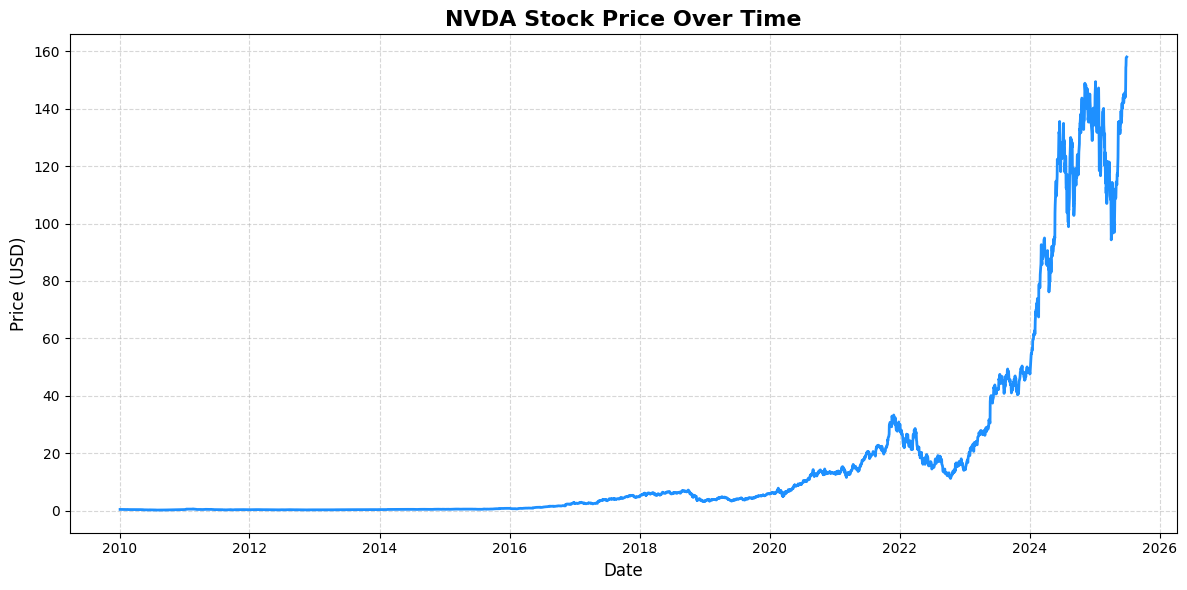

In [13]:
tmp = df[df['ticker'] == 'NVDA']
plt.figure(figsize=(12, 6))
plt.plot(tmp['Date'], tmp['Close'], color='dodgerblue', linewidth=2)

plt.title('NVDA Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df['year']= df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['weekday'] = df['Date'].dt.weekday

### Add macro features

In [15]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=START_DATE)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1 # because quaterly data
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot = gdppot[['gdppot_us_yoy','gdppot_us_qoq']].reset_index()
gdppot.rename({'DATE':'date'}, axis=1, inplace=True)
gdppot['date'] = pd.to_datetime(gdppot['date'])

full_range = pd.date_range(gdppot["date"].min(), gdppot["date"].max(), freq="MS")
gdppot = gdppot.set_index("date").reindex(full_range).rename_axis("date").reset_index()
gdppot["year"] = gdppot["date"].dt.year
gdppot["month"] = gdppot["date"].dt.month
gdppot = gdppot.ffill()

df = df.merge(gdppot[['gdppot_us_yoy','gdppot_us_qoq','year','month']], on=['year','month'], how='left')

In [16]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=START_DATE)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl = cpilfesl[['cpi_core_yoy','cpi_core_mom']].reset_index()
cpilfesl.rename({'DATE':'date'}, axis=1, inplace=True)
cpilfesl['date'] = pd.to_datetime(cpilfesl['date'])
cpilfesl["year"] = cpilfesl["date"].dt.year
cpilfesl["month"] = cpilfesl["date"].dt.month

df = df.merge(cpilfesl[['cpi_core_yoy','cpi_core_mom','year','month']], on=['year','month'], how='left')

In [17]:
def get_growth(df, column_name):
    for d in [1,3,7,30,90,252,365]:
        df[f'growth_{column_name}_{days}d'] = df[column_name] / df[column_name].shift(d)
    df.drop(column_name, axis=1, inplace=True)
    return df

In [18]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=START_DATE)
fedfunds = get_growth(fedfunds, "FEDFUNDS")
fedfunds.reset_index(inplace=True)
fedfunds.rename({'DATE':'date'}, axis=1, inplace=True)
fedfunds['date'] = pd.to_datetime(fedfunds['date'])
fedfunds["year"] = fedfunds["date"].dt.year
fedfunds["month"] = fedfunds["date"].dt.month

df = df.merge(fedfunds.drop('date', axis=1), on=['year','month'], how='left')

In [19]:
# https://fred.stlouisfed.org/series/DGS1
nums = [1,5,10]
for num in nums:
    dgs = pdr.DataReader(f"DGS{num}", "fred", start=START_DATE)
    dgs = get_growth(dgs, f"DGS{num}")
    dgs.reset_index(inplace=True)
    dgs.rename({'DATE':'Date'}, axis=1, inplace=True)
    dgs['Date'] = pd.to_datetime(dgs['Date'])
    df = df.merge(dgs, on=['Date'], how='left')

In [20]:
# Other indexes: https://stooq.com/t/

# SPX= S&P500
spx_index = pdr.get_data_stooq('^SPX', START_DATE, END_DATE)
# 252 trading days a year
# REVERSE ORDER OF THE DATA!!!
spx_index['spx_dod'] = (spx_index.Close/spx_index.Close.shift(-1)-1)
spx_index['spx_qoq'] = (spx_index.Close/spx_index.Close.shift(-63)-1)
spx_index['spx_yoy'] = (spx_index.Close/spx_index.Close.shift(-252)-1)

spx_index.reset_index(inplace=True)
spx_index['Date'] = pd.to_datetime(spx_index['Date'])

df = df.merge(spx_index[['spx_dod','spx_qoq','spx_yoy','Date']], on=['Date'], how='left')

In [21]:
# 40 largest German companies
dax_daily = yf.Ticker("^GDAXI").history(start=START_DATE)
dax_daily.rename({'Close':'GDAXI'},axis=1, inplace=True)
dax_daily = get_growth(dax_daily, 'GDAXI')
dax_daily.reset_index(inplace=True)
dax_daily['Date'] = pd.to_datetime(dax_daily['Date'].dt.date)

df = df.merge(dax_daily.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [22]:
# SNP - SNP Real Time Price. Currency in USD
snp500_daily_non_delayed = yf.Ticker("^GSPC").history(start=START_DATE)
snp500_daily_non_delayed.rename({'Close':'SP500'},axis=1, inplace=True)
snp500_daily_non_delayed = get_growth(snp500_daily_non_delayed, 'SP500')
snp500_daily_non_delayed.reset_index(inplace=True)
snp500_daily_non_delayed['Date'] = pd.to_datetime(snp500_daily_non_delayed['Date'].dt.date)

df = df.merge(snp500_daily_non_delayed.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [23]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
# 30 large, publicly owned blue-chip companies trading on the New York Stock Exchange (NYSE) and Nasdaq
dji_daily = yf.Ticker("^DJI").history(start=START_DATE)
dji_daily.rename({'Close':'DJI'},axis=1, inplace=True)
dji_daily = get_growth(dji_daily, 'DJI')
dji_daily.reset_index(inplace=True)
dji_daily['Date'] = pd.to_datetime(dji_daily['Date'].dt.date)

df = df.merge(dji_daily.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [24]:
# https://finance.yahoo.com/quote/VOO?.tsrc=fin-srch
ticker_obj = yf.Ticker("VOO")
voo_etf = ticker_obj.history(start=START_DATE)
voo_etf.rename({'Close':'VOO'},axis=1, inplace=True)
voo_etf = get_growth(voo_etf, 'VOO')
voo_etf.reset_index(inplace=True)
voo_etf['Date'] = pd.to_datetime(voo_etf['Date'].dt.date)

df = df.merge(voo_etf.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [25]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(start=START_DATE)
epi_etf_daily.rename({'Close':'EPI'},axis=1, inplace=True)
epi_etf_daily = get_growth(epi_etf_daily, 'EPI')
epi_etf_daily.reset_index(inplace=True)
epi_etf_daily['Date'] = pd.to_datetime(epi_etf_daily['Date'].dt.date)

df = df.merge(epi_etf_daily.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [26]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
ticker_obj = yf.Ticker("^VIX")
vix = ticker_obj.history(start=START_DATE)
vix.rename({'Close':'VIX'},axis=1, inplace=True)
vix = get_growth(vix, 'VIX')
vix.reset_index(inplace=True)
vix['Date'] = pd.to_datetime(vix['Date'].dt.date)

df = df.merge(vix.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [27]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF
ticker_obj = yf.Ticker("GC=F")
gold = ticker_obj.history(start=START_DATE)
gold.rename({'Close':'gold'},axis=1, inplace=True)
gold = get_growth(gold, 'gold')
gold.reset_index(inplace=True)
gold['Date'] = pd.to_datetime(gold['Date'].dt.date)

df = df.merge(gold.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [28]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/
ticker_obj = yf.Ticker("CL=F")
crude_oil = ticker_obj.history(start=START_DATE)
crude_oil.rename({'Close':'crude_oil'},axis=1, inplace=True)
crude_oil = get_growth(crude_oil, 'crude_oil')
crude_oil.reset_index(inplace=True)
crude_oil['Date'] = pd.to_datetime(crude_oil['Date'].dt.date)

df = df.merge(crude_oil.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [29]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/
ticker_obj = yf.Ticker("BZ=F")
brent_oil = ticker_obj.history(start=START_DATE)
brent_oil.rename({'Close':'brent_oil'},axis=1, inplace=True)
brent_oil = get_growth(brent_oil, 'brent_oil')
brent_oil.reset_index(inplace=True)
brent_oil['Date'] = pd.to_datetime(brent_oil['Date'].dt.date)

df = df.merge(brent_oil.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [30]:
# https://finance.yahoo.com/quote/BTC-USD/
ticker_obj = yf.Ticker("BTC-USD")
btc_usd =  ticker_obj.history(start=START_DATE)
btc_usd.rename({'Close':'btc_usd'},axis=1, inplace=True)
btc_usd = get_growth(btc_usd, 'btc_usd')
btc_usd.reset_index(inplace=True)
btc_usd['Date'] = pd.to_datetime(btc_usd['Date'].dt.date)

df = df.merge(btc_usd.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',],axis=1), on=['Date'], how='left')

In [31]:
df.shape

(1168800, 101)

In [32]:
df.to_csv('data.csv',index=False)

### Check data

In [5]:
df = pd.read_csv('data.csv')

22:21:23 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing


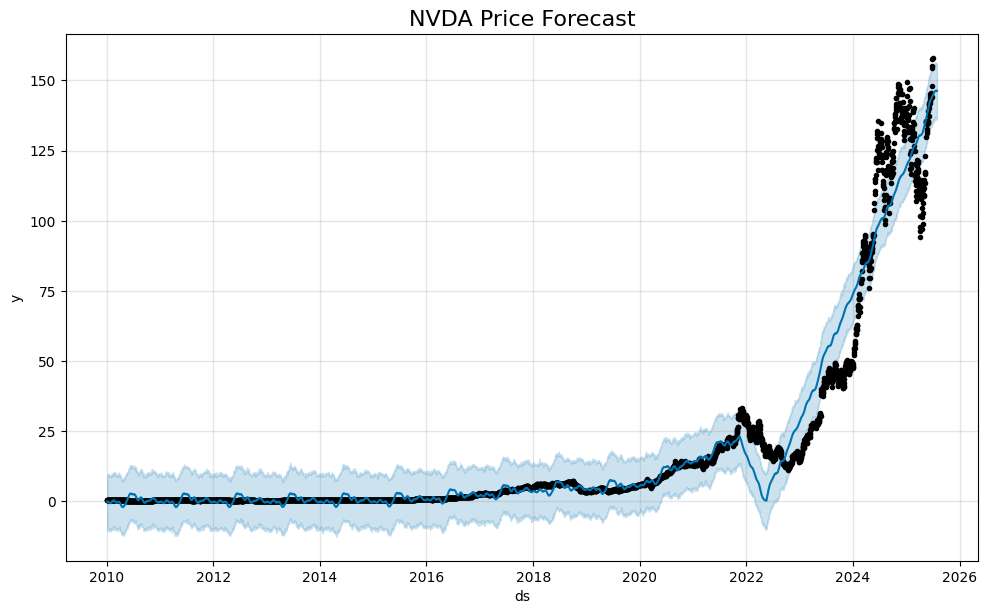

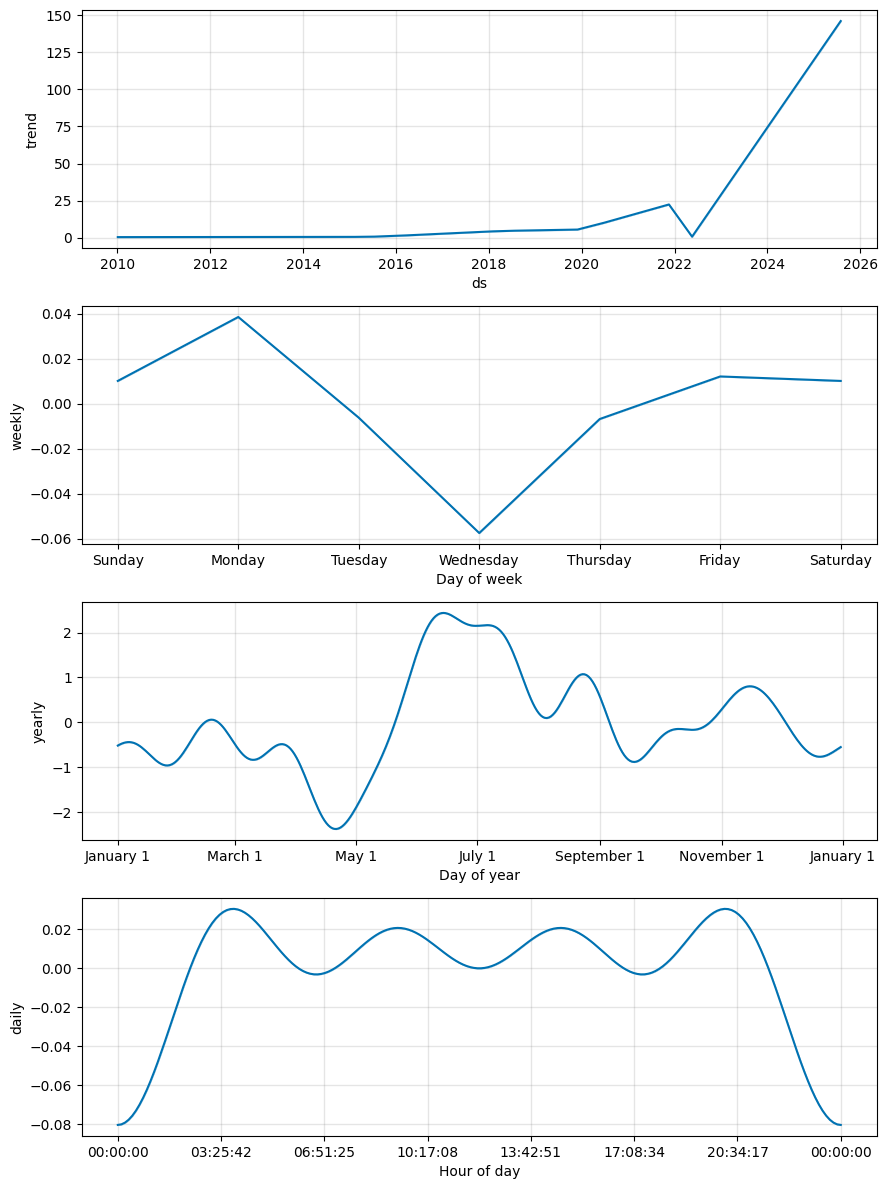

In [33]:
tmp = df[df['ticker'] == 'NVDA']
prophet_df = tmp[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30) 
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title("NVDA Price Forecast", fontsize=16)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [34]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
3916,2025-07-21,146.283277,136.143122,156.438729
3917,2025-07-22,146.245154,136.562463,156.190777
3918,2025-07-23,146.197937,136.190077,156.345909
3919,2025-07-24,146.251826,136.546937,155.924369
3920,2025-07-25,146.275038,136.851663,155.573137
3921,2025-07-26,146.280368,136.472192,155.863277
3922,2025-07-27,146.292607,136.191257,155.803406
3923,2025-07-28,146.340048,136.709420,155.333898
3924,2025-07-29,146.322896,136.539798,156.145679
3925,2025-07-30,146.309440,136.060584,156.125853


In [35]:
future_forecast = forecast[forecast['ds'] > prophet_df['ds'].max()]

In [36]:
nvda = yf.download('NVDA', start="2025-07-01", end="2025-08-01", auto_adjust=True)['Close']

[*********************100%***********************]  1 of 1 completed


In [37]:
eval_df = future_forecast[['ds', 'yhat']].rename({'ds':'Date'}, axis=1).merge(nvda.reset_index())

In [38]:
eval_df['error'] = eval_df['yhat'] - eval_df['NVDA']

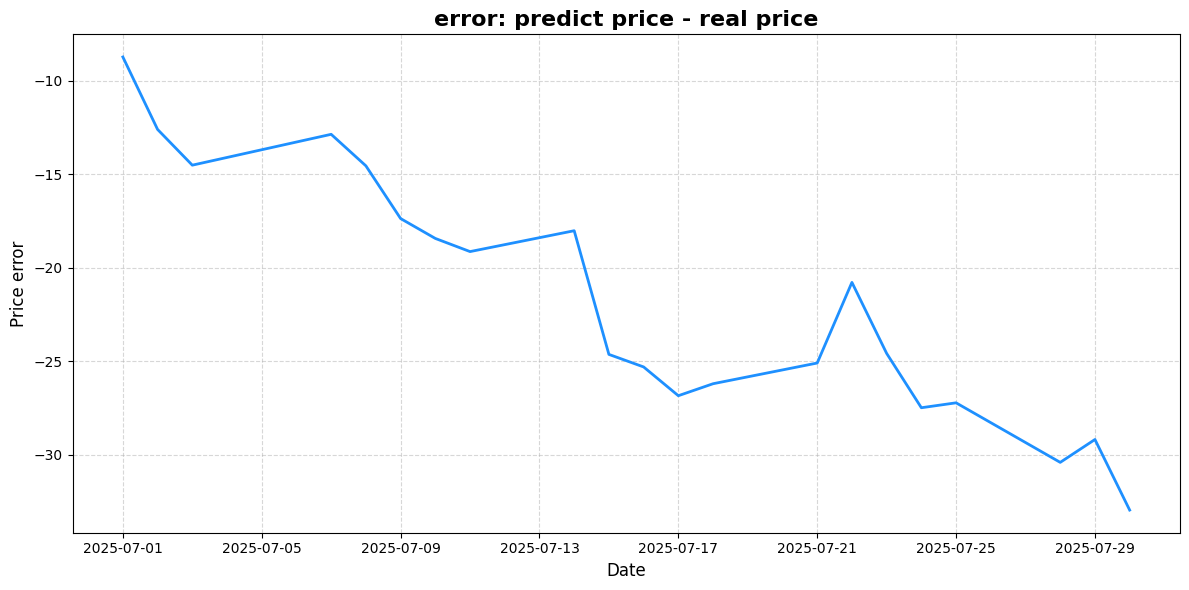

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(eval_df['Date'], eval_df['error'], color='dodgerblue', linewidth=2)

plt.title('error: predict price - real price', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price error', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

Simple startegy: Bye when SMA10 is lower and intersects SMA20, sell when they interescts again in the upper side